In [1]:
import george
from george.kernels import *
import pymc3 as pm
# note: requires pymc3 version 3.1
assert pm.__version__ == '3.1'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmap
%matplotlib inline

from ipywidgets import interact, interactive

import numpy as np
#np.random.seed(206)
import theano
import theano.tensor as tt

First, we create an array specifying the input values

In [3]:
X = np.linspace(0,10,200)[:,None]

We then define a helpful function to plot
- the covariance matrix, 
- the covariance function and 
- five samples from the GP prior

In [4]:
def plot_cov(X, K, stationary=True):
    """ 
    Display a few plots for a specific covariance function
    X: array of input locations
    K: covariance matrix
    """
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()

    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 2, hspace=.5)

    ax1 = fig.add_subplot(gs[0, 0])

    m = ax1.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Covariance Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    
    ax2 = fig.add_subplot(gs[0, 1])
    if not stationary:
        ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax2.set_title("The Diagonal of K")
        ax2.set_ylabel("k(x,x)")
    else:
        ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax2.set_title("K as a function of x - x'")
        ax2.set_ylabel("k(x,x')")
    ax2.set_xlabel("X")

    ax = fig.add_subplot(gs[1,:])
    samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
    for i in range(samples.shape[1]):
        ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
    ax.set_title("Samples from GP Prior")
    ax.set_xlabel("X")
    plt.show()

In the following example, we can play with the "squared exponential" kernel.  
Note the effect of changing the hyperparameters, the amplitude and the lengthscale.

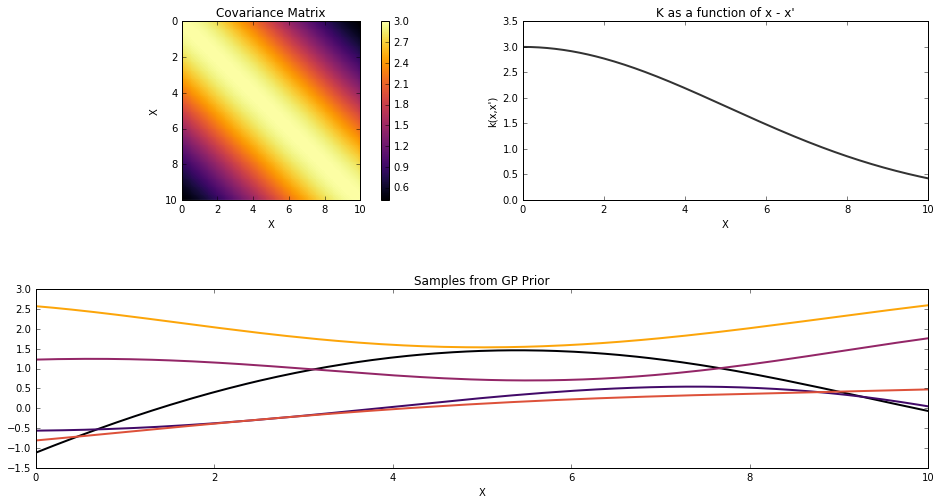

In [5]:
def ExpQuad(amp, ell):
    cov = amp * pm.gp.cov.ExpQuad(1, ell)
    K = theano.function([], cov(X))()
    plot_cov(X, K)
    
w = interact(ExpQuad, amp=(1, 5.0), ell=(0.1, 10.0))

In the following panel, we explore some kernels which take only one hyperparameter.  
For the squared exponential, the Matèrn, and the exponential kernels, this corresponds to a lengthscale.  
For the cosine kernel, the parameter is the period of the correlations.  
For the linear kernel, it corresponds to the location of the zero crossing.

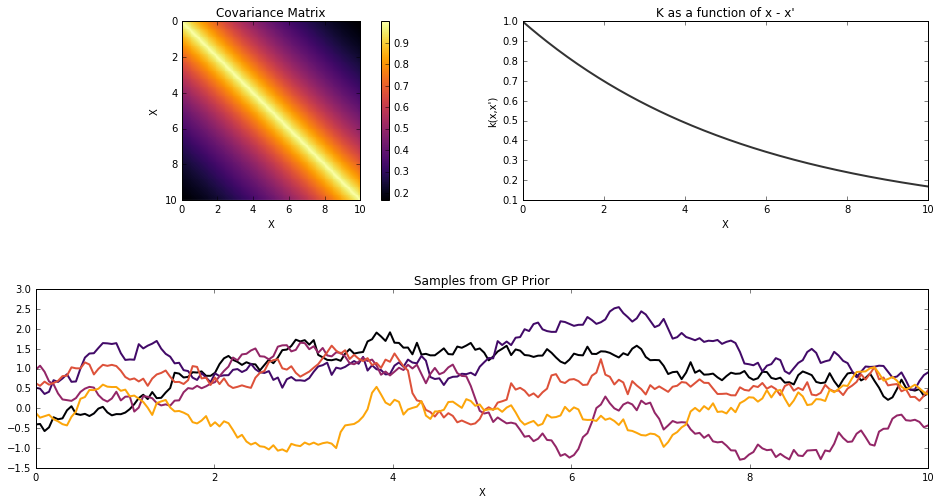

In [6]:
# PyMC3 kernels that take only one parameter
one_par_kernels = {'ExpQuad': pm.gp.cov.ExpQuad,
                   'Matern32': pm.gp.cov.Matern32,
                   'Matern52': pm.gp.cov.Matern52,
                   'Cosine': pm.gp.cov.Cosine,
                   'Exponential': pm.gp.cov.Exponential,
                   'Linear': pm.gp.cov.Linear}

def make_plot(kernel, ell):
    cov = kernel(1, ell)
    K = theano.function([], cov(X))()
    stationary = not kernel is pm.gp.cov.Linear # the linear kernel is not stationary
    plot_cov(X, K, stationary)
    
w = interact(make_plot, kernel=one_par_kernels, ell=(0.1, 10.0))

In [ ]:
#interactive_plot = interactive(ExpQuad, amp=(1., 5.), ell=(1.0, 10.0))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
#interactive_plot

Here we will repeat most of the plot function, but optionally also plot samples from the *conditional* distribution, given some data, as well as the GP prediction given those data. We do this with george, since it's slightly easier.

In [7]:
X = np.linspace(0, 10, 200)[:,None]
## generate ndata random observations
ndata = 8
xobs = np.random.uniform(0, 10, size=ndata)
yobs = np.random.randn(ndata)
yerr = np.random.randn(ndata)


def plot_cov(X, K, stationary=True, gp=None):
    """
    Almost the same as before but now can pass a gp object from george
    """
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()

    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(3, 2, hspace=.5)

    ax1 = fig.add_subplot(gs[0, 0])
    m = ax1.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Covariance Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(gs[0, 1])
    if not stationary:
        ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax2.set_title("The Diagonal of K")
        ax2.set_ylabel("k(x,x)")
    else:
        ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax2.set_title("K as a function of x - x'")
        ax2.set_ylabel("k(x,x')")
    ax2.set_xlabel("X")


    ax1 = fig.add_subplot(gs[1,:])
    if gp is not None:
        samples = gp.sample(x, size=5).T
    else:
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T
        
    for i in range(samples.shape[1]):
        ax1.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
    ax1.set_title("Samples from GP Prior")
    ax1.set_xlabel("X")

    # this part is new
    if gp is not None:
        ax2 = fig.add_subplot(gs[2,:])
        ax2.set_ylim(ax1.get_ylim())
        
        ax2.errorbar(xobs, yobs, yerr, fmt='o') # plot the data
        try:
            gp.compute(xobs, yerr)
            # samples from the conditional distribution
            samples = gp.sample_conditional(yobs, x, size=5).T
            for i in range(samples.shape[1]):
                ax2.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2, alpha=0.3);
            # the prediction
            ax2.plot(x, gp.predict(yobs, x, mean_only=True), 'g', lw=2)
        except LinAlgError:
            pass
        ax2.set_title("Samples from GP Conditional")
        ax2.set_xlabel("X")
    
    plt.show()

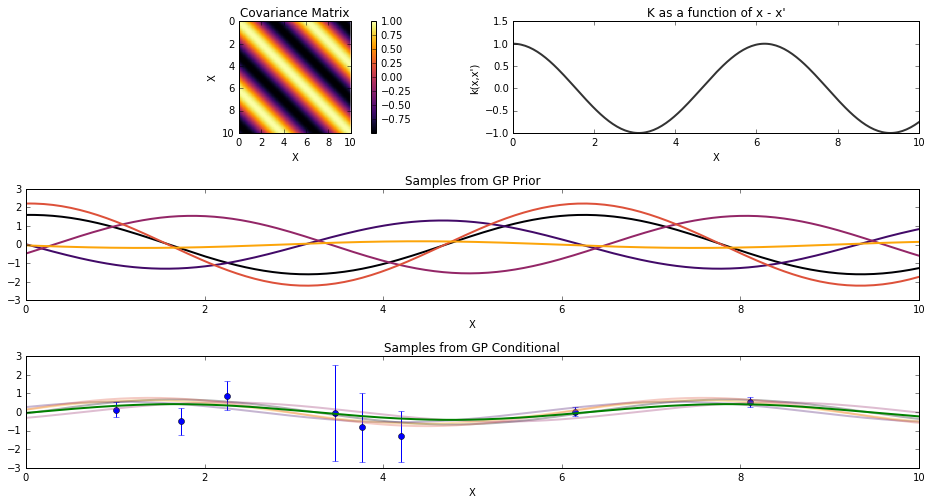

In [8]:
cov = pm.gp.cov.ExpQuad(1, 1,)
K = theano.function([], cov(X))()

kernel = CosineKernel(3.)
gp = george.GP(kernel, mean=0.)
K = gp.get_matrix(X)
#gp.sample_conditional?
#plot_cov(X, K, gp=gp)


# a few george kernels with only one parameter
one_par_kernels = {'ExpQuad': ExpSquaredKernel,
                   'Cosine': CosineKernel,
                   'Exponential': ExpKernel,
                   }

def make_plot(kernel, ell):
    k = kernel(ell)
    gp = george.GP(k, mean=0.)
    K = gp.get_matrix(X)
    plot_cov(X, K, gp=gp)

    
w = interact(make_plot, kernel=one_par_kernels, ell=(0.1, 10.0))

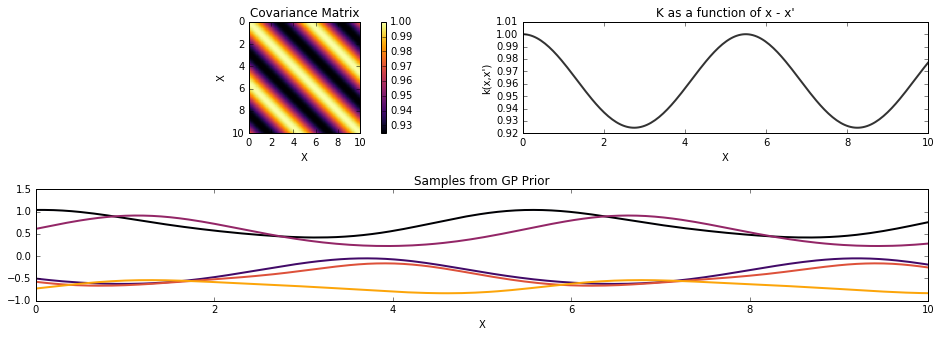

In [9]:
## this is one way to build the ExpSine2 kernel in pyMC3,
## by using wrapped inputs
def mapping(x, T):
    c = 2.0 * np.pi * (1.0 / T)
    u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
    return u


def make_plot(ell, P):
    # note that the input of the covariance function taking
    #    the inputs is 2 dimensional
    cov_exp = pm.gp.cov.ExpQuad(2, ell)
    cov = pm.gp.cov.WarpedInput(1, cov_func=cov_exp,
                                warp_func=mapping,
                                args=(P, ))

    K = theano.function([], cov(X))()
    plot_cov(X, K, True)

    
w = interact(make_plot, ell=(0.1, 10.0), P=(1., 10.))

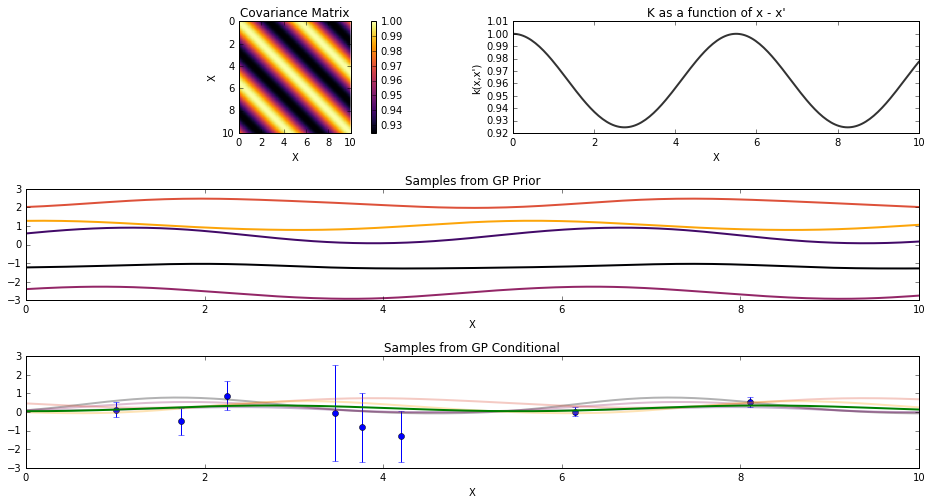

In [10]:
## in george we need to be careful with the definition of the lengthscale

def make_plot(ell, P):
    k = ExpSine2Kernel(gamma=2./ell**2, period=P)
    gp = george.GP(k, mean=0.)
    K = gp.get_matrix(X)
    plot_cov(X, K, gp=gp)

    
w = interact(make_plot, ell=(0.1, 10.0), P=(1., 10.))

### We're only missing the "quasi-periodic" kernel!